# Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

input_shape = (180,180,3)
num_classes=9

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  labels='inferred',
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  labels='inferred',
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
num_classes = len(class_names)
num_classes

9

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
# A batch size of 2000 was taken as for train_ds the batch size was 32 and the batch might not contain images from all classes. 
# Hence this additional step has been written.

all_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  labels='inferred',
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=2000)

Found 2239 files belonging to 9 classes.
Using 2016 files for training.


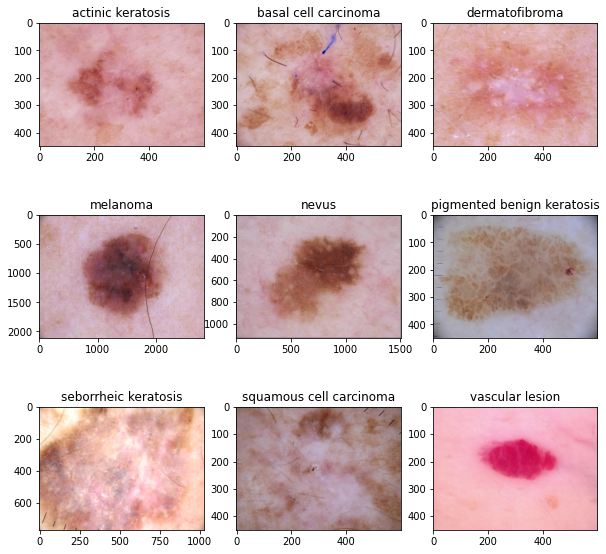

In [54]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
model1 = Sequential()
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

model1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180,180,3)))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
model1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 45, 45, 64)       0         
 pper)                                                  

### Train the model

In [16]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 370ms/step - loss: 2.0018 - accuracy: 0.2958 - val_loss: 1.6474 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 18s 329ms/step - loss: 1.6142 - accuracy: 0.4074 - val_loss: 1.4828 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 18s 328ms/step - loss: 1.4607 - accuracy: 0.4877 - val_loss: 1.4717 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 18s 326ms/step - loss: 1.3819 - accuracy: 0.5201 - val_loss: 1.3723 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 18s 326ms/step - loss: 1.3045 - accuracy: 0.5463 - val_loss: 1.3891 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 18s 320ms/step - loss: 1.2640 - accuracy: 0.5519 - val_loss: 1.3574 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 18s 319ms/step - loss: 1.2293 - accuracy: 0.5742 - val_loss: 1.3281 - val_accuracy: 0.5615

### Visualizing training results

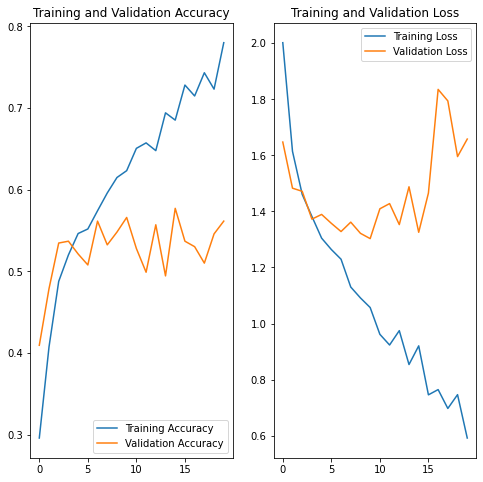

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation Model 1 - The model is overfitting as the training accuracy is high as 80% however validation accuracy is only 53%

### Model 2 with Data Augmetation

In [18]:
#data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",seed=123),
  layers.RandomRotation(0.2,seed=123),
  layers.RandomZoom(0.2,seed=123)
])

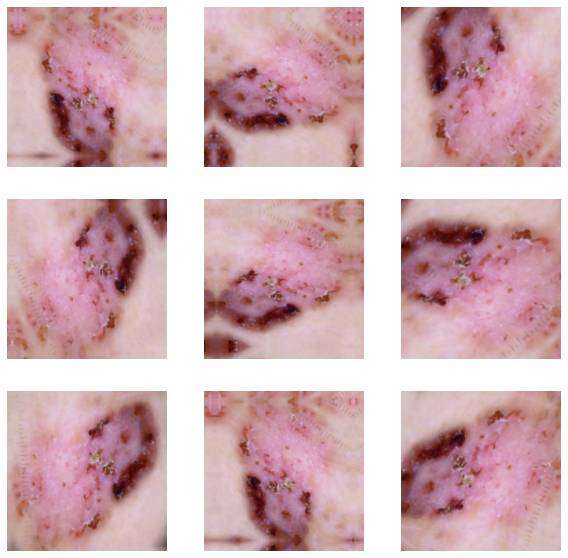

In [20]:
plt.figure(figsize=(10, 10))

for images,labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmented_images[0].numpy().astype('uint8')
    plt.imshow(augmented_image)
    plt.axis("off")

### Create the model, compile and train the model


In [24]:
model2 = Sequential()
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))
model2.add(data_augmentation)

model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180,180,3)))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(9, activation='softmax'))

### Compiling the model

In [25]:
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_20 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_21 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_22 (ModuleWr  (None, 90, 90, 64)       18496     
 apper)                                                          
                                                      

### Training the model

In [27]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 340ms/step - loss: 2.2378 - accuracy: 0.2260 - val_loss: 1.8831 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 19s 337ms/step - loss: 1.8279 - accuracy: 0.3287 - val_loss: 1.9789 - val_accuracy: 0.2796
Epoch 3/20
56/56 [==============================] - 19s 340ms/step - loss: 1.6545 - accuracy: 0.3990 - val_loss: 1.4980 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 19s 337ms/step - loss: 1.4750 - accuracy: 0.4682 - val_loss: 1.4584 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 19s 335ms/step - loss: 1.4561 - accuracy: 0.4939 - val_loss: 1.4754 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 19s 338ms/step - loss: 1.4255 - accuracy: 0.5017 - val_loss: 1.4349 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 19s 339ms/step - loss: 1.4163 - accuracy: 0.4888 - val_loss: 1.3736 - val_accuracy: 0.5145

### Visualizing the results

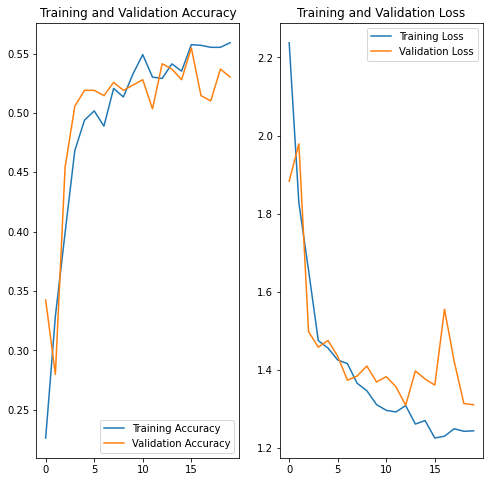

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation Model 2 - The gap in accuracy of training and validation has now reduced which means the issue of over fitting is resolved. However, now both training and validation accuracy is low around 55% which means the model is underfitting.

#### **Model 3 : Class Imbalance Rectification using Augmentor** 
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
data = dict()
for i in class_names:
  data[i] = 0

for images,labels in train_ds:
  l=labels.numpy()
  s = sum(l)
  for i in range(9):
    data[class_names[i]] = data[class_names[i]]+s[i]

data

{'actinic keratosis': 92.0,
 'basal cell carcinoma': 309.0,
 'dermatofibroma': 77.0,
 'melanoma': 352.0,
 'nevus': 277.0,
 'pigmented benign keratosis': 370.0,
 'seborrheic keratosis': 58.0,
 'squamous cell carcinoma': 142.0,
 'vascular lesion': 115.0}

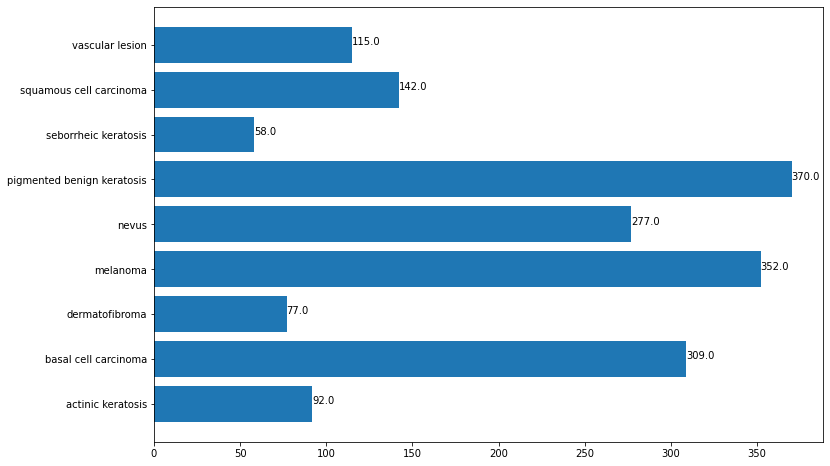

In [30]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(data)), list(data.values()))
plt.yticks(range(len(data)), list(data.keys()))

for index, value in enumerate(data.values()):
    plt.text(value, index,
             str(value))
 
plt.show()

#### **Observation:** There is a class imbalance in the train data set.
#### - seborrheic keratosis, actinic keratosis, dermatofibroma classes have low number of data samples.
#### - Whereas, melanoma, basal cell carcinoma, pigmented benign keratosis have higher samples.


#### **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test') 

path_to_training_dataset = pathlib.Path(str(data_dir_train) + '/')
import Augmentor
for i in class_names:
    path_to_training_dataset = pathlib.Path(str(data_dir_train) + '/' + i)
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2C38885910>: 100%|██████████| 500/500 [00:02<00:00, 189.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2C38888650>: 100%|██████████| 500/500 [00:02<00:00, 178.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C4A310E50>: 100%|██████████| 500/500 [00:02<00:00, 182.15 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2C49F5A290>: 100%|██████████| 500/500 [00:08<00:00, 61.97 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F2C4AB88850>: 100%|██████████| 500/500 [00:07<00:00, 68.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C388F5F90>: 100%|██████████| 500/500 [00:02<00:00, 178.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2C38538810>: 100%|██████████| 500/500 [00:03<00:00, 130.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2C4AAC2090>: 100%|██████████| 500/500 [00:02<00:00, 173.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2C38948810>: 100%|██████████| 500/500 [00:03<00:00, 162.38 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_35ade46f-c2f8-4bea-a551-b0b4d5056624.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032404.jpg_0c3dd298-27f2-4898-b93f-6d04b71915d4.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_d2de699d-5ee4-46bb-8ad5-a1134692056c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_0ceb2458-baf1-421a-8096-5a9c1bda7b97.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_be65f2ef-a5f7-4b9b-821e-e23bd4e503dd.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/output/actinic keratosis_o

In [35]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list_old

['/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026857.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0025957.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026194.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026457.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026040.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026171.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026575.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026525.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic keratosis/ISIC_0026848.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Melanoma/Data/Train/actinic

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lesion_list_old

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [41]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

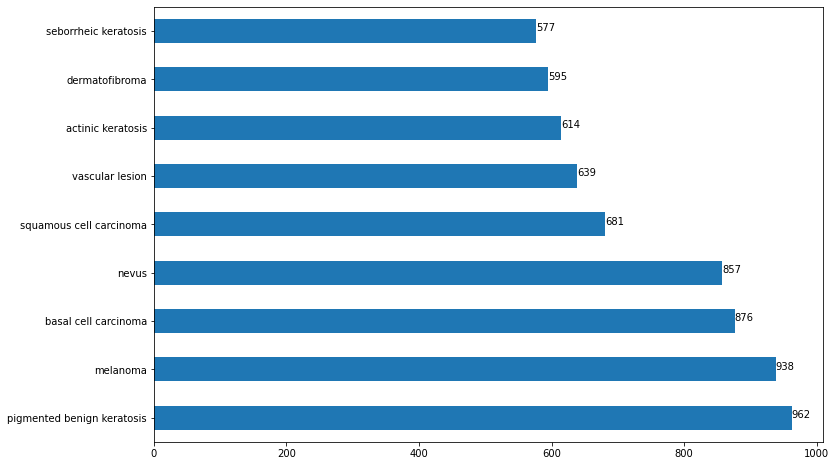

In [42]:
plt.figure(figsize=(12, 8))
new_df['Label'].value_counts().plot(kind = 'barh')
for index, value in enumerate(new_df['Label'].value_counts()):
    plt.text(value, index,
             str(value))
    
plt.show()

#### **Observation** : So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [44]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  labels='inferred',
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  labels='inferred',
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

The model is built with batch normalisation

In [46]:
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 9s 44ms/step - loss: 2.2656 - accuracy: 0.3221 - val_loss: 2.9874 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 7s 43ms/step - loss: 1.7377 - accuracy: 0.4089 - val_loss: 2.9838 - val_accuracy: 0.2108
Epoch 3/30
169/169 [==============================] - 7s 43ms/step - loss: 1.5021 - accuracy: 0.4726 - val_loss: 2.4183 - val_accuracy: 0.2687
Epoch 4/30
169/169 [==============================] - 7s 44ms/step - loss: 1.3476 - accuracy: 0.5080 - val_loss: 1.3319 - val_accuracy: 0.5152
Epoch 5/30
169/169 [==============================] - 7s 44ms/step - loss: 1.2010 - accuracy: 0.5584 - val_loss: 1.2250 - val_accuracy: 0.5241
Epoch 6/30
169/169 [==============================] - 7s 43ms/step - loss: 1.0835 - accuracy: 0.6129 - val_loss: 1.2442 - val_accuracy: 0.5375
Epoch 7/30
169/169 [==============================] - 7s 43ms/step - loss: 0.9914 - accuracy: 0.6309 - val_loss: 1.7882 - val_accuracy: 0.4254

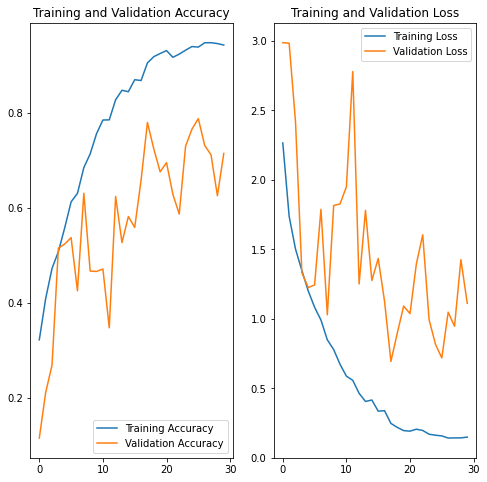

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We observed the model is still overfitting to some extent and some erratic behaviour. The above model is rebuilt removing the batch normalisation steps.

In [49]:
model3 = Sequential()

model3.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)))

model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(180,180,3)))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_45 (ModuleWr  (None, 180, 180, 64)     1792      
 apper)                                                          
                                                                 
 module_wrapper_46 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                                 
 module_wrapper_47 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                                 
 module_wrapper_48 (ModuleWr  (None, 90, 90, 64)       36928     
 apper)                                               

#### **Todo:**  Train your model

In [52]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 84s 493ms/step - loss: 2.2566 - accuracy: 0.1317 - val_loss: 2.1865 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 82s 485ms/step - loss: 2.1781 - accuracy: 0.1398 - val_loss: 2.1873 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 83s 488ms/step - loss: 2.1755 - accuracy: 0.1397 - val_loss: 2.1881 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 81s 478ms/step - loss: 2.1777 - accuracy: 0.1411 - val_loss: 2.1840 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 80s 473ms/step - loss: 2.1750 - accuracy: 0.1439 - val_loss: 2.0840 - val_accuracy: 0.2160
Epoch 6/30
169/169 [==============================] - 80s 471ms/step - loss: 2.0684 - accuracy: 0.1992 - val_loss: 1.8468 - val_accuracy: 0.3177
Epoch 7/30
169/169 [==============================] - 80s 471ms/step - loss: 1.9089 - accuracy: 0.2619 - val_loss: 1.6510 - val_ac

#### **Todo:**  Visualize the model results

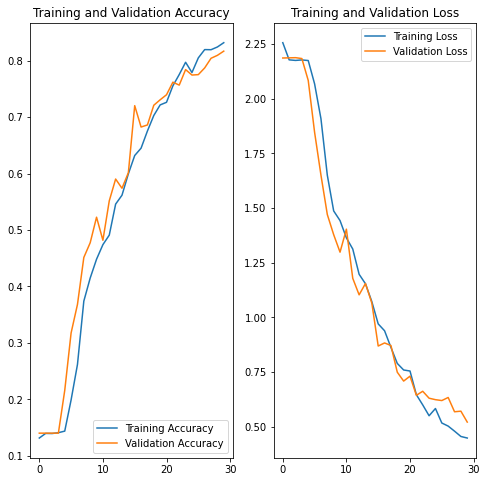

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Did you get rid of underfitting/overfitting? Did class rebalance help?**

#### **Observation Model 3**  - With the final model, the issue of overfitting in model 1 and underfitting in model 2 has been resolved. The classes are now more balaced. The accuracy is around 83% and there is not major gap between training and validation accuracy.

